In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,choice
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.498196,0.496158,0.496615,0.497996,0.500308,0.500480,0.498694,0.498919,0.502075,0.500342,0.491940,0.496369,1.434500
std,0.289019,0.288155,0.289132,0.285976,0.287776,0.294243,0.291651,0.291692,0.293180,0.287970,0.284162,0.290476,0.830695
min,0.000735,0.000184,0.000245,0.000037,0.000036,0.000103,0.000285,0.000127,0.000561,0.000452,0.000425,0.000153,0.000000
25%,0.247766,0.248665,0.251427,0.247912,0.249987,0.238205,0.239685,0.249062,0.244836,0.257808,0.246923,0.235549,1.000000
50%,0.499612,0.500399,0.500191,0.500036,0.500532,0.500267,0.500054,0.500272,0.500176,0.500163,0.499659,0.499937,2.000000
75%,0.750896,0.736318,0.745482,0.741605,0.750104,0.764595,0.760645,0.750211,0.760566,0.755377,0.730856,0.738764,2.000000
max,0.999981,0.997841,0.999861,0.998499,0.998889,0.999907,0.999105,0.999392,0.999346,0.999825,0.999901,0.999928,2.000000


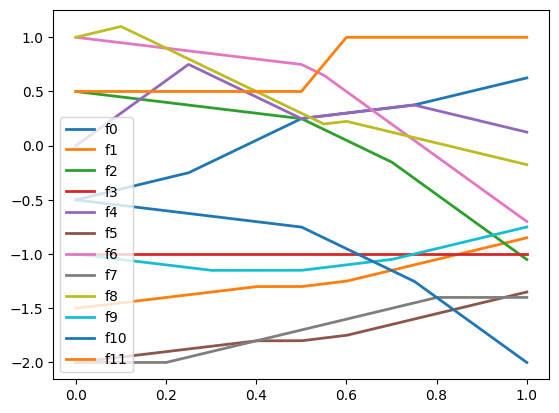

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr, feature_names):
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)


def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=softmax(u))[0]

n_utility = 3 
regression = n_utility == 1
f_per_utility = 4
x_arr = generate_x(2000, n_utility * f_per_utility, 0.5, 0.5)
# x_arr[:, 1] = x_arr[:, 0]
# x_arr[:, 2] = x_arr[:, 0]
x_arr_test = generate_x(1000, n_utility * f_per_utility, 0.5, 0.5)
# x_arr_test[:, 1] = x_arr_test[:, 0]
# x_arr_test[:, 2] = x_arr_test[:, 0]
sp = np.array(
    [
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.34, 0.5, 0.55, 1],
        [0, 0.2, 0.4, 0.8, 1],
        [0, 0.1, 0.55, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
    ]
)
betas = np.array(
    [
        [1, 2, 0.5, 1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 0, 0],
        [3, -2, 0.5, -1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 1, 1, 0],
        [1, -2, 0.5, -1],
        [-0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 5, 0],
        [1, 1, 0.9, -1],
        [0.5, -1, 0.5, 1],
        [-0.5, -0.5, 2, -3],
        [0, -1, 0, 0],
    ]
)
intercept = [-0.5, -1.5, 0.5, -1, 0, -2, 1, -2, 1, -1, -0.5, 0.5, -2, 0, 0, 0.5]

ind = [i for i in range(4 * n_utility) if i % 4 < f_per_utility]
sp = [sp[i] for i in ind]
betas = [betas[i] for i in ind]
intercept = [intercept[i] for i in ind]

feature_names = [f"f{i}" for i in range(f_per_utility*n_utility)]

u_idx = [(i * f_per_utility, (i+1) * f_per_utility) for i in range(n_utility)]

x_plot = np.linspace(1e-4, 1, 1000).reshape(-1, 1)
for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
    y_plot = apply_linear_feature(
        x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
    ).values
    plt.plot(x_plot, y_plot, label=feature_names[i], linewidth=2)

plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_linear_feature(
    x_arr, sp, betas, feature_names, intercept=intercept
)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_linear_feature(
    x_arr_test, sp, betas, feature_names, intercept=intercept
)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

## Fake gradient boosting iteration with pandas

In [14]:
import copy
def compute_preds(X):
    preds = softmax(X, axis=1)
    return preds

def compute_grads_and_hess(preds, labels, num_classes=3):
    grads = preds - labels
    factor = num_classes / (num_classes - 1)
    hess = factor * preds * (1 - preds)
    hess = np.maximum(hess, 1e-6)
    return grads, hess

def compute_split_gain(grads, hess, split, feature):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    no_split_gain = np.sum(grads) ** 2 / np.sum(hess)
    left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
    right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)
    bigger_gain_left = left_gain > right_gain

    gain = left_gain + right_gain - no_split_gain
    return gain, bigger_gain_left

def find_best_split(X, grads, hess, linear_trees=False, from_split_point=False):
    best_gain = -np.inf
    best_split = None
    best_feature = None
    best_bigger_gain_left = None
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    for feature in range(X.shape[1]):
        unique_values = np.unique(X[:, feature])
        for split in unique_values:
            if linear_trees and from_split_point:
                grads_ = grads * (X[:, feature] - split)
                hess_ = hess * (X[:, feature] - split)**2
            elif linear_trees:
                grads_ = grads * (X[:, feature])
                hess_ = hess * (X[:, feature])**2
            else:
                grads_ = grads
                hess_ = hess
            gain, bigger_gain_left = compute_split_gain(grads_, hess_, split, X[:, feature])
            if gain > best_gain:
                best_gain = copy.deepcopy(gain)
                best_split = copy.deepcopy(split)
                best_feature = copy.deepcopy(feature)
                best_bigger_gain_left = copy.deepcopy(bigger_gain_left)

    return best_feature, best_split, best_gain, best_bigger_gain_left

def compute_leaf_value(grads, hess, feature, split, linear_trees=False, from_split_point=False):
    no_split_value = - np.sum(grads) / np.sum(hess)
    left_mask = feature <= split
    right_mask = feature > split

    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_intercept = - np.sum(left_grads) / np.sum(left_hess)
    right_intercept = - np.sum(right_grads) / np.sum(right_hess)

    if linear_trees and from_split_point:
        grads = grads * (feature - split)
        hess = hess * (feature - split)**2
    elif linear_trees:
        grads = grads * (feature)
        hess = hess * (feature)**2

    
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_value = - np.sum(left_grads) / np.sum(left_hess)
    right_value = - np.sum(right_grads) / np.sum(right_hess)

    return left_value, right_value, no_split_value, left_intercept, right_intercept

def boost(X, y, preds, num_classes=3, linear_trees=False, from_split_point=False):
    grads, hess = compute_grads_and_hess(preds, y, num_classes=num_classes)
    feature, split, gain, bigger_left = find_best_split(X, grads, hess, linear_trees=linear_trees, from_split_point=from_split_point)
    left_value, right_value, no_split_value, left_intercept, right_intercept = compute_leaf_value(grads, hess, X[:, feature].reshape(-1), split, linear_trees=linear_trees, from_split_point=from_split_point)

    return feature, split, left_value, right_value, gain, no_split_value, bigger_left, left_intercept, right_intercept

In [13]:
class Tree:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.tree = None

    def fit(self, X, y, preds, num_classes=3):
        self.tree = self._build_tree(X, y, preds, num_classes=num_classes)

    def _build_tree(self, X, y, preds, num_classes=3):

        feature, split, left_value, right_value, gain, no_split_value, bigger_left, left_intercept, right_intercept = boost(X, y, preds, num_classes=num_classes, linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        if gain <= 0:
            return None
        
        # if self.from_split_point:
        #     if bigger_left:
        #         right_value = 0
        #     else:
        #         left_value = 0

        return {
            "feature": feature,
            "split": split,
            "left_value": -left_value if (self.linear_trees and not self.from_split_point) else left_value,
            # "left_value": left_value,
            "right_value": right_value,
            "gain": gain,
            "left_constant": split * right_value  if not self.from_split_point else None,
            # "left_constant": split * right_value + no_split_value if not self.from_split_point else None,
            "right_constant": split * -left_value if not self.from_split_point else None,
            # "right_constant": split * -left_value + no_split_value if not self.from_split_point else None,
            "left_intercept": left_intercept,
            "right_intercept": right_intercept,
            "full_intercept": no_split_value,
        }

In [14]:
class Ensemble:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.trees = []

    def fit(self, X, y, preds, num_classes=3):
        tree = Tree(linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        tree.fit(X, y, preds, num_classes=num_classes)
        self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))
        for tree in self.trees:
            if tree.tree is not None:
                split = tree.tree["split"]
                feature = tree.tree["feature"]
                left_value = tree.tree["left_value"]
                right_value = tree.tree["right_value"]
                left_constant = tree.tree["left_constant"]
                right_constant = tree.tree["right_constant"]
                left_intercept = tree.tree["left_intercept"]
                right_intercept = tree.tree["right_intercept"]
                full_intercept = tree.tree["full_intercept"]

                x_f = X[:, feature]

                if self.linear_trees and self.from_split_point:
                    preds[x_f <= split] += left_value * (x_f[x_f <= split] - split) + full_intercept
                    preds[x_f > split] += right_value * (x_f[x_f > split] - split) + full_intercept
                elif self.linear_trees:
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] + left_intercept + right_intercept
                    preds[x_f <= split] += left_value * x_f[x_f <= split] - right_constant + full_intercept
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] 
                    # preds[x_f > split] += right_value * x_f[x_f > split] + right_intercept + right_intercept
                    preds[x_f > split] += right_value * x_f[x_f > split] - left_constant + full_intercept
                    # preds = preds - left_constant - right_constant
                    # preds[x_f > split] += right_value * x_f[x_f > split] 
                else:
                    preds[x_f <= split] += left_value
                    preds[x_f > split] += right_value

        return preds

In [15]:
class BoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, num_classes=3, linear_trees=False, from_split_point=False, feature_indices=None):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.ensemble = [Ensemble(linear_trees=self.linear_trees, from_split_point=self.from_split_point) for _ in range(num_classes)]
        self.feature_indices = feature_indices
        if self.feature_indices is None:
            self.feature_indices = [(i, i+1) for i in range(num_classes)]

    def fit(self, X, y, X_test=None, y_test=None):
        self.initial_preds = np.zeros((1, self.num_classes))
        for j in range(self.num_classes):
            self.initial_preds[:, j] = np.log(np.mean(y==j))
        raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
        preds = softmax(raw_preds, axis=1)
        print("Initial train cel:", cross_entropy(preds, y))
        if X_test is not None and y_test is not None:
            test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
            test_preds = softmax(test_preds, axis=1)
            print("Initial test cel:", cross_entropy(test_preds, y_test))
            
        for i in range(self.n_estimators):
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            for j in range(self.num_classes):
                ensemble = self.ensemble[j]
                ensemble.fit(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]], y == j, preds[:, j], num_classes=self.num_classes)
                raw_preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
            preds = softmax(raw_preds, axis=1)
            print("Train cel:", cross_entropy(preds, y))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                for j in range(self.num_classes):
                    ensemble = self.ensemble[j]
                    test_preds[:, j] += self.learning_rate * ensemble.predict(X_test[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
                test_preds = softmax(test_preds, axis=1)
                print("Test cel:", cross_entropy(test_preds, y_test))

    def predict(self, X, utilities=False):
        preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()

        for j in range(self.num_classes):
            ensemble = self.ensemble[j]
            preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])

        return softmax(preds, axis=1) if not utilities else preds

In [21]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values

feature_indices = [(i * f_per_utility, (i + 1) * f_per_utility) for i in range(n_utility)]

model = BoostingModel(n_estimators=20, learning_rate=0.1, feature_indices=feature_indices)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, _, _, _, _, _= tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}")

preds = model.predict(X_test)
cel = cross_entropy(preds, y_test)
print(f"Cross-entropy loss: {cel}")

Initial train cel: 0.8665065688364659
Initial test cel: 0.8179526293862074


C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_31572\4037606457.py:23: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)


Train cel: 0.8586408065346729
Test cel: 0.8125263353251223
Train cel: 0.8523639655593002
Test cel: 0.8083794207170204
Train cel: 0.847280512675607
Test cel: 0.8050015149765648
Train cel: 0.8431538809787837
Test cel: 0.8023803655439451
Train cel: 0.8397119144720798
Test cel: 0.7999995552187615
Train cel: 0.8368135424462635
Test cel: 0.7980951998264676
Train cel: 0.8342793483545331
Test cel: 0.7966571332645913
Train cel: 0.8320779907906701
Test cel: 0.7952192486876686
Train cel: 0.8300300132646146
Test cel: 0.7941294766824756
Train cel: 0.8281205559662473
Test cel: 0.7927274112202821
Train cel: 0.8263153079026708
Test cel: 0.7919492960716722
Train cel: 0.8245967808901562
Test cel: 0.7912053538381256
Train cel: 0.8229733320498367
Test cel: 0.7901872576378166
Train cel: 0.8214634501011021
Test cel: 0.7893390767181747
Train cel: 0.8200138980747725
Test cel: 0.7884761270258568
Train cel: 0.8186649711126729
Test cel: 0.7882034685279373
Train cel: 0.817387553859441
Test cel: 0.7874613954666191

In [22]:
lr = 0.1
md = 1
verbose = 2
mono = False 
# monotonicity_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_0 = [0, 1, -1, 0] if mono else [0] * 17
# monotonicity_0 = [1] if mono else [0] * 17
l1 = 0
l2 = 0
min_data_in_leaf = 1 
min_sum_hessian_in_leaf = 0
min_data_in_bin = 1
mb = 2000
variables_0 = feature_names[:f_per_utility]
dico1 = []
for i, v in enumerate(variables_0):
    dico1.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# monotonicity_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_1 = [0, 1, -1, 1] if mono else [0]*17
# monotonicity_1 = [1] if mono else [0]*17
variables_1 = feature_names[f_per_utility:2*f_per_utility]
dico2 = []
for i, v in enumerate(variables_1):
    dico2.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })
    
# monotonicity_3 = [0 ,0, -1, 1] if mono else [0]*23
# monotonicity_3 = [1] if mono else [0]*23
monotonicity_3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1] if mono else [0]*23
variables_3 = feature_names[2*f_per_utility:3*f_per_utility]
dico3 = []
for i, v in enumerate(variables_3):

    dico3.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_3[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

monotonicity_4 = [0, 0, 0, -1] if mono else [0]*20
# monotonicity_4 = [1] if mono else [0]*20
variables_4 = feature_names[3*f_per_utility:]
dico4 = []
for i, v in enumerate(variables_4):
    dico4.append({
        "utility": [3],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_4[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# rum_structure = dico1 + dico2 + dico3 #+ dico4
if n_utility == 4:
    rum_structure = dico1 + dico2 + dico3 + dico4
elif n_utility == 3:
    rum_structure = dico1 + dico2 + dico3
else:
    rum_structure = dico1
boost_from_param_space = [False] * len(rum_structure)
# boost_from_param_space = [True] * len(rum_structure)

In [23]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": n_utility,  # important
    "verbosity": 2,  # specific RUMBoost parameter
    "num_iterations": 20,
    # "early_stopping_round": 10,
    # "max_booster_to_update": 23 * 4,
    # "max_booster_to_update": 17 * 4,
    # "max_booster_to_update": 8,
    # "max_booster_to_update": n_utility * f_per_utility,
    # "max_booster_to_update": 1,
    "max_booster_to_update": n_utility,
    # "boost_from_parameter_space": boost_from_param_space + boost_from_param_space2,
    "boost_from_parameter_space": boost_from_param_space, #+ [False]*len(rum_structure2),
    "verbose_interval": 1,
    "optim_interval": 1,
}

In [24]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [25]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [26]:
import pandas as pd
import lightgbm
from rumboost.rumboost import rum_train
# features and label column names
features = [f for f in dataset.columns if f != "choice"]
label = "choice"
# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    dataset, label=dataset[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    dataset_test, label=dataset_test[label], free_raw_data=False
)

In [27]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, valid_sets=[lgb_test_set], torch_tensors=torch_tensors)

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\pwl-experiment\src\rumboost\rumboost.py:2731: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\pwl-experiment\src\rumboost\rumboost.py:3259: UserWarning: Assuming the learning rate is 0.1 for all boosters
  warnings.warn(f"Assuming the learning rate is {lr} for all boosters")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000288 seconds, init for row-wise cost 0.000330 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2000
[LightGB

In [29]:
for booster in LPMC_model_fully_trained.boosters:
    try:
        print(booster.trees_to_dataframe())
    except:
        continue

    tree_index  node_depth node_index left_child right_child parent_index  \
0            0           1       0-S0       0-L0        0-L1         None   
1            0           2       0-L0       None        None         0-S0   
2            0           2       0-L1       None        None         0-S0   
3            1           1       1-S0       1-L0        1-L1         None   
4            1           2       1-L0       None        None         1-S0   
5            1           2       1-L1       None        None         1-S0   
6            2           1       2-S0       2-L0        2-L1         None   
7            2           2       2-L0       None        None         2-S0   
8            2           2       2-L1       None        None         2-S0   
9            3           1       3-S0       3-L0        3-L1         None   
10           3           2       3-L0       None        None         3-S0   
11           3           2       3-L1       None        None         3-S0   

In [30]:
import lightgbm
train_set = lightgbm.Dataset(
    dataset["f0"].values.reshape(-1, 1), label=dataset[label].values, free_raw_data=False
)
test_set = lightgbm.Dataset(
    dataset_test["f0"].values.reshape(-1, 1), label=dataset_test[label].values, free_raw_data=False
)
params = {
    "learning_rate": 0.1,
    "num_leaves": 32,
    "max_depth": 1,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 0,
    "min_data_in_bin": 1,
    "max_bin": 2000,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": n_utility,
    "verbosity": 2,
    "eval_metric": "multi_logloss",
    "monotone_constraints": [1],
    "monotone_constraints_method": "advanced",
}

model = lightgbm.train(params, train_set, num_boost_round=20, valid_sets=[test_set])
y_preds_train = model.predict(dataset["f0"].values.reshape(-1, 1))
cel_train = cross_entropy(y_preds_train, dataset[label].values)
print(f"Train cross-entropy loss: {cel_train}")
y_preds = model.predict(dataset_test["f0"].values.reshape(-1, 1))
cel = cross_entropy(y_preds, dataset_test[label].values)
print(f"Cross-entropy loss: {cel}")

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000099 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Start training from score -1.505078
[LightGBM] [Info] Start training from score -2.107841
[LightGBM] [Info] Start training from score -0.420833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [99]:
model.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-L0,0-L1,None,Column_0,28.259001,0.480596,<=,left,None,-1.262310,0.000000,1000.0
1,0,2,0-L0,None,None,0-S0,None,NaN,NaN,None,None,None,-1.294601,143.356621,471.0
2,0,2,0-L1,None,None,0-S0,None,NaN,NaN,None,None,None,-1.233557,161.009878,529.0
3,1,1,1-S0,1-L0,1-L1,None,Column_0,2.179800,0.997683,<=,left,None,-0.967584,0.000000,1000.0
4,1,2,1-L0,None,None,1-S0,None,NaN,NaN,None,None,None,-0.967936,352.693192,998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,58,2,58-L0,None,None,58-S0,None,NaN,NaN,None,None,None,-0.005331,191.115747,535.0
154,58,2,58-L1,None,None,58-S0,None,NaN,NaN,None,None,None,0.006420,161.236403,465.0
155,59,1,59-S0,59-L0,59-L1,None,Column_0,0.140207,0.888808,<=,left,None,0.000000,0.000000,1000.0
156,59,2,59-L0,None,None,59-S0,None,NaN,NaN,None,None,None,-0.000884,296.981437,881.0


## Gradient boosting with linear trees

In [15]:
import copy
def compute_preds(X):
    preds = softmax(X, axis=1)
    return preds

def compute_grads_and_hess(preds, labels, num_classes=3):
    if num_classes > 1:
        grads = preds - labels
        factor = num_classes / (num_classes - 1)
        hess = factor * preds * (1 - preds)
        hess = np.maximum(hess, 1e-6)
    else:
        grads = 2 *(preds - labels)
        hess = 2 * np.ones_like(preds)
    return grads, hess

def compute_split_gain(grads, hess, split, feature, one_sided=False, grads_x=None, hess_x=None, from_split_point=False):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]
    if grads_x is not None and hess_x is not None:
        left_grads_x = grads_x[left_mask]
        right_grads_x = grads_x[right_mask]
        left_hess_x = hess_x[left_mask]
        right_hess_x = hess_x[right_mask]
        
        no_split_gain = np.sum(grads_x) ** 2 / np.sum(hess_x)
        left_gain = np.sum(left_grads_x) ** 2 / np.sum(left_hess_x)
        right_gain = np.sum(right_grads_x) ** 2 / np.sum(right_hess_x)
        if split < 0.05 or split > 0.95:
            left_gain_x = 0
            right_gain_x = 0
        else:
            if not from_split_point:
                beta_l = - np.sum(left_grads_x) / np.sum(left_hess_x)
                right_gain_x = np.sum(right_grads * beta_l * split) + 0.5 * np.sum(right_hess * beta_l ** 2 * split ** 2)
                left_gain = left_gain + right_gain_x
                beta_r = - np.sum(right_grads_x) / np.sum(right_hess_x)
                left_gain_x = np.sum(left_grads * beta_r * split) + 0.5 * np.sum(left_hess * beta_r ** 2 * split ** 2)
                right_gain = right_gain + left_gain_x
    else:
        no_split_gain = np.sum(grads) ** 2 / np.sum(hess)
        left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
        right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)

    bigger_gain_left = left_gain > right_gain

    if one_sided:
        if bigger_gain_left:
            if from_split_point:
                right_gain = left_gain_x
            else:
                right_gain = 0
        else:
            if from_split_point:
                left_gain = right_gain_x
            else:
                left_gain = 0
    gain = left_gain + right_gain - no_split_gain
    return gain, bigger_gain_left

def find_best_split(X, grads, hess, linear_trees=False, from_split_point=False):
    best_gain = -np.inf
    best_split = None
    best_feature = None
    best_bigger_gain_left = None
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    for feature in range(X.shape[1]):
        unique_values = np.unique(X[:, feature])
        for split in unique_values:
            if linear_trees and from_split_point:
                grads_ = grads * (X[:, feature] - split)
                hess_ = hess * (X[:, feature] - split)**2
                one_sided = False
            elif linear_trees:
                grads_ = grads * (X[:, feature])
                hess_ = hess * (X[:, feature])**2
                one_sided = True
            else:
                grads_ = None
                hess_ = None 
                one_sided = False
            gain, bigger_gain_left = compute_split_gain(grads, hess, split, X[:, feature], one_sided=one_sided, grads_x=grads_, hess_x=hess_, from_split_point=from_split_point)
            if gain > best_gain:
                best_gain = copy.deepcopy(gain)
                best_split = copy.deepcopy(split)
                best_feature = copy.deepcopy(feature)
                best_bigger_gain_left = copy.deepcopy(bigger_gain_left)

    return best_feature, best_split, best_gain, best_bigger_gain_left

def compute_leaf_value(grads, hess, feature, split, linear_trees=False, from_split_point=False):
    no_split_value = - np.sum(grads) / np.sum(hess)
    left_mask = feature <= split
    right_mask = feature > split

    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_intercept = - np.sum(left_grads) / np.sum(left_hess)
    right_intercept = - np.sum(right_grads) / np.sum(right_hess)

    if linear_trees and from_split_point:
        grads = grads * (feature - split)
        hess = hess * (feature - split)**2
    elif linear_trees:
        grads = grads * (feature)
        hess = hess * (feature)**2

    
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_value = - np.sum(left_grads) / np.sum(left_hess)
    right_value = - np.sum(right_grads) / np.sum(right_hess)

    return left_value, right_value, no_split_value, left_intercept, right_intercept

def boost(X, y, preds, num_classes=3, linear_trees=False, from_split_point=False):
    grads, hess = compute_grads_and_hess(preds, y, num_classes=num_classes)
    feature, split, gain, bigger_left = find_best_split(X, grads, hess, linear_trees=linear_trees, from_split_point=from_split_point)
    left_value, right_value, no_split_value, left_intercept, right_intercept = compute_leaf_value(grads, hess, X[:, feature].reshape(-1), split, linear_trees=linear_trees, from_split_point=from_split_point)

    return feature, split, left_value, right_value, gain, no_split_value, bigger_left, left_intercept, right_intercept

In [16]:
class Tree:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.tree = None

    def fit(self, X, y, preds, num_classes=3):
        self.tree = self._build_tree(X, y, preds, num_classes=num_classes)

    def _build_tree(self, X, y, preds, num_classes=3):

        feature, split, left_value, right_value, gain, no_split_value, bigger_left, left_intercept, right_intercept = boost(X, y, preds, num_classes=num_classes, linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        if gain <= 0:
            return None
        
        if self.linear_trees and not self.from_split_point:
            if bigger_left:
                right_value = 0
            else:
                left_value = 0

        return {
            "feature": feature,
            "split": split,
            "left_value": left_value if (self.linear_trees and not self.from_split_point) else left_value,
            # "left_value": left_value,
            "right_value": right_value,
            "gain": gain,
            "left_constant": split * right_value  if not self.from_split_point else None,
            # "left_constant": split * right_value + no_split_value if not self.from_split_point else None,
            "right_constant": split * left_value if not self.from_split_point else None,
            # "right_constant": split * -left_value + no_split_value if not self.from_split_point else None,
            "left_intercept": left_intercept,
            "right_intercept": right_intercept,
            "full_intercept": no_split_value,
        }

In [17]:
class Ensemble:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.trees = []

    def fit(self, X, y, preds, num_classes=3):
        tree = Tree(linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        tree.fit(X, y, preds)
        self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))
        for tree in self.trees:
            if tree.tree is not None:
                split = tree.tree["split"]
                feature = tree.tree["feature"]
                left_value = tree.tree["left_value"]
                right_value = tree.tree["right_value"]
                left_constant = tree.tree["left_constant"]
                right_constant = tree.tree["right_constant"]
                left_intercept = tree.tree["left_intercept"]
                right_intercept = tree.tree["right_intercept"]
                full_intercept = tree.tree["full_intercept"]

                x_f = X[:, feature]

                if self.linear_trees and self.from_split_point:
                    # preds[x_f <= split] += left_value * (x_f[x_f <= split] - split)
                    # preds[x_f > split] += right_value * (x_f[x_f > split] - split) 
                    preds[x_f <= split] += left_value * (x_f[x_f <= split] - split) + full_intercept
                    preds[x_f > split] += right_value * (x_f[x_f > split] - split) + full_intercept
                elif self.linear_trees:
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] - left_constant + full_intercept
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] + right_constant + full_intercept
                    preds[x_f <= split] += left_value * x_f[x_f <= split] + right_constant 
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] 
                    # preds[x_f > split] += right_value * x_f[x_f > split] - right_constant + full_intercept
                    # preds[x_f > split] += right_value * x_f[x_f > split] + left_constant + full_intercept
                    preds[x_f > split] += right_value * x_f[x_f > split] + left_constant 
                    # preds = preds - left_constant - right_constant + full_intercept
                    # preds = preds - left_constant - right_constant - full_intercept
                    # preds[x_f > split] += right_value * x_f[x_f > split] 
                else:
                    preds[x_f <= split] += left_value
                    preds[x_f > split] += right_value

        return preds

In [18]:
class BoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, num_classes=3, linear_trees=False, from_split_point=False, feature_indices=None):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.ensemble = [Ensemble(linear_trees=self.linear_trees, from_split_point=self.from_split_point) for _ in range(num_classes)]
        self.feature_indices = feature_indices
        if self.feature_indices is None:
            self.feature_indices = [(i, i+1) for i in range(num_classes)]

    def fit(self, X, y, X_test=None, y_test=None):
        self.initial_preds = np.zeros((1, self.num_classes))
        if self.num_classes > 1:
            for j in range(self.num_classes):
                self.initial_preds[:, j] = np.log(np.mean(y==j))
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            preds = softmax(raw_preds, axis=1)
            print("Initial train cel:", cross_entropy(preds, y))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                test_preds = softmax(test_preds, axis=1)
                print("Initial test cel:", cross_entropy(test_preds, y_test))
        else:
            self.initial_preds[:, 0] = np.mean(y)
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            preds = raw_preds
            print("Initial train mse:", np.mean((preds - y.reshape(-1, 1))**2))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                print("Initial test mse:", np.mean((test_preds - y_test.reshape(-1, 1))**2))
            
        for i in range(self.n_estimators):
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            for j in range(self.num_classes):
                ensemble = self.ensemble[j]
                target = y == j if self.num_classes > 1 else y
                ensemble.fit(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]], target, preds[:, j], num_classes=self.num_classes)
                raw_preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
            if self.num_classes > 1:
                preds = softmax(raw_preds, axis=1)
                print("Train cel:", cross_entropy(preds, y))
            else:
                preds = raw_preds
                print("Train mse:", np.mean((preds - y.reshape(-1, 1))**2))

            if X_test is not None and y_test is not None:
                raw_test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                for j in range(self.num_classes):
                    ensemble = self.ensemble[j]
                    raw_test_preds[:, j] += self.learning_rate * ensemble.predict(X_test[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
                if self.num_classes > 1:
                    test_preds = softmax(raw_test_preds, axis=1)
                    print("Test cel:", cross_entropy(test_preds, y_test))
                else:
                    test_preds = raw_test_preds
                    print("Test mse:", np.mean((test_preds - y_test.reshape(-1, 1))**2))

    def predict(self, X, utilities=False):
        preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()

        for j in range(self.num_classes):
            ensemble = self.ensemble[j]
            preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])

        return softmax(preds, axis=1) if not utilities else preds

In [19]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values

feature_indices = [(i * f_per_utility, (i + 1) * f_per_utility) for i in range(n_utility)]

model = BoostingModel(n_estimators=1, learning_rate=0.2, num_classes=n_utility, linear_trees=True, from_split_point=False, feature_indices=feature_indices)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, left_constant, right_constant, left_intercept, right_intercept, full_intercept = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}, Left constant: {left_constant}, Right constant: {right_constant}, Left intercept: {left_intercept}, Right intercept: {right_intercept}, Full intercept: {full_intercept}")

if n_utility > 1:
    preds = model.predict(X_test)
    cel = cross_entropy(preds, y_test)
    print(f"Cross-entropy loss: {cel}")
else:
    preds = model.predict(X_test, utilities=True)
    mse = np.mean((preds - y_test.reshape(-1, 1))**2)
    print(f"Mean squared error: {mse}")

Initial train cel: 0.8665065688364659
Initial test cel: 0.8179526293862074


C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_24740\1000589807.py:32: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads_x) ** 2 / np.sum(right_hess_x)


Train cel: 0.8601435768406561
Test cel: 0.8120770463115317
Feature: 3, Split: 0.05729408483780285, Gain: 224.0153148322852, Left value: -16.165180777096452, Right value: 0, Left constant: 0.0, Right constant: -0.9261692388613839, Left intercept: -0.5649727409896773, Right intercept: 0.035742560434753615, Full intercept: 2.7426246391382385e-17
Feature: 0, Split: 0.1261431143342121, Gain: 72.57092326106147, Left value: -5.171106231818214, Right value: 0, Left constant: 0.0, Right constant: -0.6522994446346018, Left intercept: -0.3318034567522211, Right intercept: 0.04396489744055497, Full intercept: 1.9970705840064083e-16
Feature: 0, Split: 0.06953351457452572, Gain: 264.3036667207039, Left value: 12.727487514932012, Right value: 0, Left constant: 0.0, Right constant: 0.8849869386166193, Left intercept: 0.5328263112244881, Right intercept: -0.04226954546681025, Full intercept: 1.6804572159436648e-16
Cross-entropy loss: 0.8120770463115317


In [20]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values
feature_indices = [(i * f_per_utility, (i + 1) * f_per_utility) for i in range(n_utility)]

model = BoostingModel(n_estimators=10, learning_rate=0.1, num_classes=n_utility, linear_trees=True, from_split_point=True, feature_indices=feature_indices)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, left_constant, right_constant, left_intercept, right_intercept, full_intercept = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}, Full intercept: {full_intercept}, Left intercept: {left_intercept}, Right intercept: {right_intercept}")

if n_utility > 1:
    preds = model.predict(X_test)
    cel = cross_entropy(preds, y_test)
    print(f"Cross-entropy loss: {cel}")
else:
    preds = model.predict(X_test, utilities=True)
    mse = np.mean((preds - y_test.reshape(-1, 1))**2)
    print(f"Mean squared error: {mse}")

Initial train cel: 0.8665065688364659
Initial test cel: 0.8179526293862074


C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_24740\1000589807.py:31: RuntimeWarning: invalid value encountered in scalar divide
  left_gain = np.sum(left_grads_x) ** 2 / np.sum(left_hess_x)
C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_24740\1000589807.py:32: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads_x) ** 2 / np.sum(right_hess_x)


Train cel: 0.8601675801304047
Test cel: 0.8130004855406089
Train cel: 0.8549126585969279
Test cel: 0.8090025810186454
Train cel: 0.8506422507217419
Test cel: 0.80576859015859
Train cel: 0.8469004689974438
Test cel: 0.8030995702754729
Train cel: 0.8437948013242365
Test cel: 0.8008860071612494
Train cel: 0.8411440908949903
Test cel: 0.7990593102108591
Train cel: 0.8391120019489324
Test cel: 0.797242059458653
Train cel: 0.8373790355308477
Test cel: 0.7956869480222979
Train cel: 0.8356688324540616
Test cel: 0.7946682474943193
Train cel: 0.8342506476823202
Test cel: 0.7935319937135805
Feature: 0, Split: 0.18384160022084123, Gain: 17.317671919416465, Left value: 4.4644455608578735, Right value: 0.5026936663565411, Full intercept: 2.7426246391382385e-17, Left intercept: -0.48032231868209035, Right intercept: 0.1086688752873644
Feature: 0, Split: 0.18384160022084123, Gain: 15.251601203021792, Left value: 4.2571995549849655, Right value: 0.4503138542599606, Full intercept: -0.002892287146403402

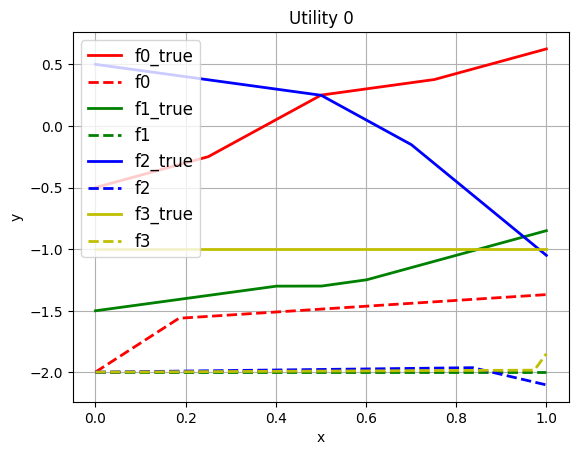

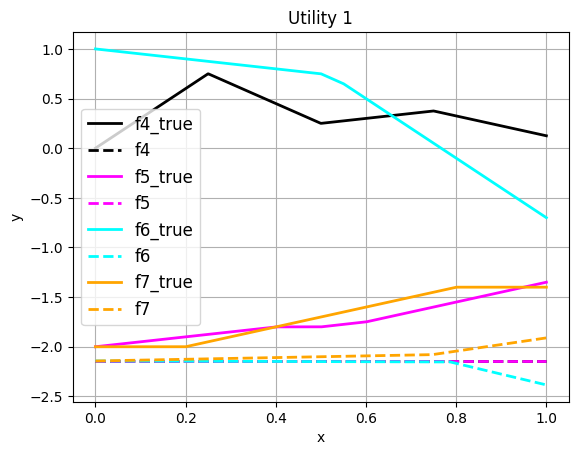

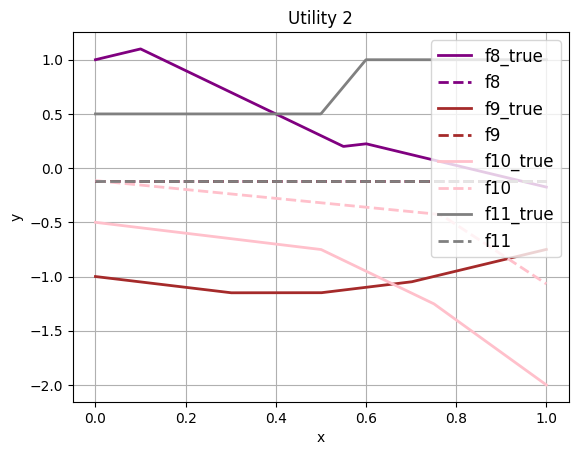

In [11]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot

    if n_utility == 2:
        y_plot.append(model.predict(plot_dataset.values, utilities=True))
    else:
        y_plot.append(model.predict(plot_dataset.values, utilities=True)[:, i // f_per_utility])

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true.append(apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values)
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [98]:
lr = 0.1
md = 1
verbose = 2
mono = False 
# monotonicity_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_0 = [1, 1, -1, 0] if mono else [0] * 17
# monotonicity_0 = [1] if mono else [0] * 17
l1 = 0
l2 = 0
min_data_in_leaf = 1
min_sum_hessian_in_leaf = 0
min_data_in_bin = 1
mb = 250
bf=1
bfr=0
variables_0 = feature_names[:f_per_utility]
dico1 = []
for i, v in enumerate(variables_0):
    dico1.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "objective": "regression",
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
            # "num_classes": 1,
            "bagging_fraction": bf,
            "bagging_freq": bfr,
        },
        "shared": False,
    })

# monotonicity_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_1 = [0, 1, -1, 1] if mono else [0]*17
# monotonicity_1 = [1] if mono else [0]*17
variables_1 = feature_names[f_per_utility:2*f_per_utility]
dico2 = []
for i, v in enumerate(variables_1):
    dico2.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })
    
monotonicity_3 = [0 ,0, -1, 1] if mono else [0]*23
# monotonicity_3 = [1] if mono else [0]*23
# monotonicity_3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1] if mono else [0]*23
variables_3 = feature_names[2*f_per_utility:3*f_per_utility]
dico3 = []
for i, v in enumerate(variables_3):

    dico3.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_3[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

monotonicity_4 = [0, 0, 0, -1] if mono else [0]*20
# monotonicity_4 = [1] if mono else [0]*20
variables_4 = feature_names[3*f_per_utility:]
dico4 = []
for i, v in enumerate(variables_4):
    dico4.append({
        "utility": [3],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_4[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# rum_structure = dico1 + dico2 + dico3 #+ dico4
if n_utility == 4:
    rum_structure = dico1 + dico2 + dico3 + dico4
elif n_utility == 3:
    rum_structure = dico1 + dico2 + dico3
else:
    rum_structure = dico1
# boost_from_param_space = [False] * len(rum_structure)
boost_from_param_space = [True] * len(rum_structure)

In [105]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": n_utility,  # important
    "verbosity": 2,  # specific RUMBoost parameter
    "num_iterations": 200,
    # "early_stopping_round": 10,
    # "max_booster_to_update": 23 * 4,
    # "max_booster_to_update": 17 * 4,
    # "max_booster_to_update": 8,
    # "max_booster_to_update": n_utility * f_per_utility,
    # "max_booster_to_update": 1,
    "max_booster_to_update": n_utility,
    # "boost_from_parameter_space": boost_from_param_space + boost_from_param_space2,
    "boost_from_parameter_space": boost_from_param_space, #+ [False]*len(rum_structure2),
    "verbose_interval": 1,
    "optim_interval": 1,
    "objective": "regression",
}

In [106]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [107]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [108]:
import pandas as pd
import lightgbm
from rumboost.rumboost import rum_train
# features and label column names
features = [f for f in dataset.columns if f != "choice"]
label = "choice"

# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    dataset, label=dataset[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    dataset_test, label=dataset_test[label], free_raw_data=False
)

In [109]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, valid_sets=[lgb_test_set], torch_tensors=torch_tensors)

/home/nicolas-salvade/pwl-rumboost-experiment/src/rumboost/rumboost.py:2758: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[1]------NCE value on train set : 0.2395
---------NCE value on test set 1: 1.3250
[2]------NCE value on train set : 0.2245
---------NCE value on test set 1: 1.3143
[3]------NCE value on train set : 0.2142
---------NCE value on test set 1: 1.3280
[4]------NCE value on train set : 0.2026
---------NCE value on test set 1: 1.3209
[5]------NCE value on train set : 0.1949
---------NCE value on test set 1: 1.3329
[6]------NCE value on train set : 0.1860
---------NCE value on test set 1: 1.329

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

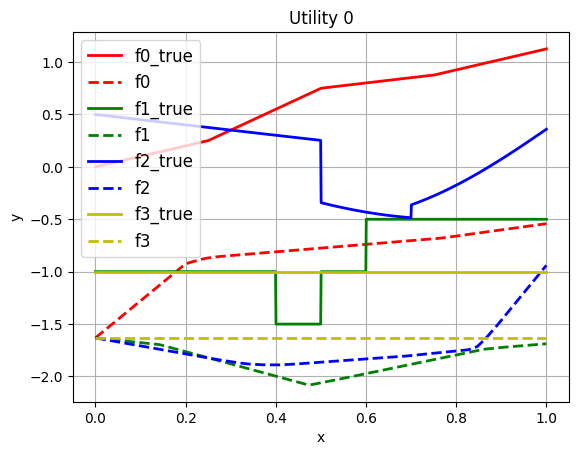

In [110]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot
    plot_dataset_lgb = lightgbm.Dataset(plot_dataset, free_raw_data=False)

    if n_utility == 2:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True))
    else:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True)[:, i // f_per_utility])
    if LPMC_model_fully_trained.device is not None:
        y_plot[-1] = y_plot[-1].cpu().numpy()

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        if i % f_per_utility == 0:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        elif i % f_per_utility == 1:
            y_plot_true = apply_constant_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 2:
            y_plot_true = apply_sinusoidal_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 3:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        if i % f_per_utility == 0:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        elif i % f_per_utility == 1:
            y_plot_true = apply_constant_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 2:
            y_plot_true = apply_sinusoidal_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 3:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        # y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [54]:
for booster in LPMC_model_fully_trained.boosters:
    try:
        print(booster.trees_to_dataframe())
    except:
        continue

    tree_index  node_depth node_index left_child right_child parent_index  \
0            0           1       0-S0       0-L0        0-L1         None   
1            0           2       0-L0       None        None         0-S0   
2            0           2       0-L1       None        None         0-S0   
3            1           1       1-S0       1-L0        1-L1         None   
4            1           2       1-L0       None        None         1-S0   
5            1           2       1-L1       None        None         1-S0   
6            2           1       2-S0       2-L0        2-L1         None   
7            2           2       2-L0       None        None         2-S0   
8            2           2       2-L1       None        None         2-S0   
9            3           1       3-S0       3-L0        3-L1         None   
10           3           2       3-L0       None        None         3-S0   
11           3           2       3-L1       None        None         3-S0   

In [100]:

from interpret.glassbox import APLRClassifier, ExplainableBoostingClassifier, APLRRegressor
from lightgbm import train
model_aplr = APLRRegressor(random_state=1, m=100, max_interaction_level=0, verbosity=2, min_observations_in_split=1, v = 0.2, bins=2000, cv_folds=2)
# model_aplr = ExplainableBoostingClassifier(random_state=42)
model_aplr.fit(dataset[features].values, dataset["choice"], X_names=features)

Fold: 0. Boosting step: 1. Model terms: 1. Terms eligible: 4. Validation error: 2.11966.
Fold: 0. Boosting step: 2. Model terms: 2. Terms eligible: 4. Validation error: 0.981173.
Fold: 0. Boosting step: 3. Model terms: 2. Terms eligible: 4. Validation error: 0.483448.
Fold: 0. Boosting step: 4. Model terms: 2. Terms eligible: 4. Validation error: 0.246372.
Fold: 0. Boosting step: 5. Model terms: 3. Terms eligible: 4. Validation error: 0.143454.
Fold: 0. Boosting step: 6. Model terms: 4. Terms eligible: 4. Validation error: 0.0880048.
Fold: 0. Boosting step: 7. Model terms: 5. Terms eligible: 4. Validation error: 0.0594562.
Fold: 0. Boosting step: 8. Model terms: 6. Terms eligible: 4. Validation error: 0.0446251.
Fold: 0. Boosting step: 9. Model terms: 7. Terms eligible: 4. Validation error: 0.0361705.
Fold: 0. Boosting step: 10. Model terms: 8. Terms eligible: 4. Validation error: 0.0309179.
Fold: 0. Boosting step: 11. Model terms: 9. Terms eligible: 4. Validation error: 0.0279479.
Fol

In [101]:
from rumboost.metrics import cross_entropy
# preds = model_aplr.predict_class_probabilities(dataset_test[features[0]].values)
if n_utility > 1:
    preds = model_aplr.predict_proba(dataset_test[features].values)
    print(cross_entropy(preds, dataset_test["choice"].astype(int).values))
else:
    preds = model_aplr.predict(dataset_test[features].values)
    mse = np.mean((preds - dataset_test["choice"].values)**2)
    print(f"Mean squared error: {mse}")

Mean squared error: 0.002857116017656334


In [99]:

from interpret import show
show(model_aplr.explain_global())

<!-- http://127.0.0.1:7001/127067092303632/ -->

In [67]:
lgb_train_set.construct()

In [23]:
LPMC_model_fully_trained.boosters[0].get_split_value_histogram("f0")

(array([ 4,  3,  2,  2,  3,  9,  3,  1,  6,  9,  0,  5,  0,  4,  6,  0, 17,
         9,  3,  0,  3,  8,  0,  0,  2,  0,  0,  0,  1]),
 array([0.02168464, 0.04405916, 0.06643367, 0.08880818, 0.1111827 ,
        0.13355721, 0.15593172, 0.17830624, 0.20068075, 0.22305526,
        0.24542978, 0.26780429, 0.2901788 , 0.31255332, 0.33492783,
        0.35730234, 0.37967686, 0.40205137, 0.42442588, 0.44680039,
        0.46917491, 0.49154942, 0.51392393, 0.53629845, 0.55867296,
        0.58104747, 0.60342199, 0.6257965 , 0.64817101, 0.67054553]))

In [ ]:
import json

class LinearTree:
    def __init__(self, x, monotonic_constraint = 0, max_bins=255):
        """ x must be 1d shape"""
        self.bin_edges, self.histograms, self.bin_indices = self.build_lightgbm_style_histogram(x, max_bins)
        self.bin_indices = self.bin_indices.reshape(1, -1).repeat(self.bin_edges.shape[0], axis=0)
        self.x = x
        self.monotonic_constraint = monotonic_constraint
        self.upper_bound = 0
        self.lower_bound = 0
        self.x_minus_bin_edges = self.x[None, :] - self.bin_edges[1:-1, None] 
        self.split_and_leaf_values = {
                        "splits": np.array([x.min(), x.max()]),
                        "constants": np.array([0.0, 0.0]),
                        "leaves": np.array([0.0]),
                        "value_at_splits": np.array([0.0, 0.0]),
                    }
        self.feature_importance = {"gain": np.array([])}
        # x_0 - e_0, x_0 - e_1, ...
        # x_1 - e_0, x_1 - e_1, ...


    def build_lightgbm_style_histogram(feature_values, max_bins=255):

        percentiles = np.linspace(0, 100, max_bins + 1)
        bin_edges = np.unique(np.percentile(feature_values, percentiles))

        bin_indices = np.digitize(feature_values, bins=bin_edges[1:-1], right=True)

        histogram = np.bincount(bin_indices, minlength=len(bin_edges) - 1)

        return bin_edges, histogram, bin_indices

    def update(self, _, fobj):

        grad, hess = fobj(_, _)
        grad_x = grad * self.x_minus_bin_edges
        hess_x = hess * self.x_minus_bin_edges

        N = self.bin_indices.max()+1
        id = self.bin_indices + (N*np.arange(self.bin_indices.shape[0]))[:,None]

        grad_x_binned = np.bincount(id.ravel(), weights=grad_x.ravel()).reshape(-1, N)
        hess_x_binned = np.bincount(id.ravel(), weights=hess_x.ravel()).reshape(-1, N)

        arange = np.arange(grad_x_binned.shape[0])
        edgerange = np.arange(grad_x_binned.shape[0]-1) + 1
        mask = arange[None, :] < edgerange[:, None]

        left_gain = grad_x_binned[mask].sum(axis=0) ** 2 / hess_x_binned[mask].sum(axis=0)
        left_leaf = - grad_x_binned[mask].sum(axis=0) / hess_x_binned[mask].sum(axis=0)

        right_gain = grad_x_binned[~mask].sum(axis=0) ** 2 / hess_x_binned[~mask].sum(axis=0)
        right_leaf = - grad_x_binned[~mask].sum(axis=0) / hess_x_binned[~mask].sum(axis=0)

        no_split_gain = grad_x_binned.sum() / hess_x_binned.sum()

        if self.monotonic_constraint == 1:
            left_gain[left_leaf < self.lower_bound] = -np.inf
            right_gain[right_leaf < self.lower_bound] = -np.inf
        
        if self.monotonic_constraint == -1:
            left_gain[left_leaf > self.upper_bound] = -np.inf
            right_gain[right_leaf > self.upper_bound] = -np.inf

        gain = left_gain + right_gain - no_split_gain

        best_index = np.argmax(gain)
        best_threshold = self.bin_edges[best_index+1]
        best_left_leaf = left_leaf[best_index]
        best_right_leaf = right_leaf[best_index]
        best_gain = gain[best_index]
        self.feature_importance["gain"].append(best_gain)

        self._update_linear_constants(best_threshold, (best_left_leaf, best_right_leaf))

    def _update_linear_constants(self, split_values, leaf_values):
        """

        """
        s = split_values
        l_0 = leaf_values[0]
        l_1 = leaf_values[1]
        if (
            s in self.split_and_leaf_values["splits"]
        ):  # if the split value exists already
            index = np.searchsorted(self.split_and_leaf_values["splits"], s)
            self.split_and_leaf_values["leaves"][:index] += l_0

            self.split_and_leaf_values["leaves"][index:] += l_1

            self.split_and_leaf_values["constants"] = np.concatenate(
                (
                    self.split_and_leaf_values["constants"][: index + 1]
                    + l_1 * s, 
                    self.split_and_leaf_values["constants"][index + 1 :]
                    + l_0 * s,
                )
            )
        else:
            index = np.searchsorted(self.split_and_leaf_values["splits"], s)
            self.split_and_leaf_values["splits"] = np.insert(
                self.split_and_leaf_values["splits"], index, s
            )

            self.split_and_leaf_values["leaves"] = np.concatenate(
                (
                    self.split_and_leaf_values["leaves"][:index] + l_0,
                    self.split_and_leaf_values["leaves"][index - 1 :] + l_1,
                )
            )

            self.split_and_leaf_values["constants"] = np.concatenate(
                (
                    self.split_and_leaf_values["constants"][: index + 1]
                    + l_1 * s,
                    self.split_and_leaf_values["constants"][index:]
                    + l_0 * s,
                )
            )

        self.upper_bound = np.max(self.split_and_leaf_values["leaves"])
        self.lower_bound = np.min(self.split_and_leaf_values["leaves"])

        leaves = self.split_and_leaf_values["leaves"]
        splits = self.split_and_leaf_values["splits"]
        all_leaves = np.concatenate((leaves[0].reshape(-1), leaves))
        constants = self.split_and_leaf_values["constants"]

        self.split_and_leaf_values["value_at_splits"] = (
            all_leaves * splits + constants
        )
    
    def eval_train(self, feval):
        pass

    def eval_valid(self, feval):
        pass

    def model_to_string(self, _, __, ___) -> str:
        """
        Serialize the model to a JSON string.
        """
        model_dict = {
            "bin_edges": self.bin_edges.tolist(),
            "histograms": self.histograms.tolist(),
            "split_and_leaf_values": {
                k: v.tolist() for k, v in self.split_and_leaf_values.items()
            },
            "monotonic_constraint": self.monotonic_constraint,
            "upper_bound": self.upper_bound,
            "lower_bound": self.lower_bound,
            "feature_importance": self.feature_importance
        }
        return json.dumps(model_dict)

    def model_from_string(self, s: str):
        """
        Load the model from a JSON string.
        """
        model_dict = json.loads(s)
        self.bin_edges = np.array(model_dict["bin_edges"])
        self.histograms = np.array(model_dict["histograms"])
        self.split_and_leaf_values = {
            k: np.array(v) for k, v in model_dict["split_and_leaf_values"].items()
        }
        self.monotonic_constraint = model_dict["monotonic_constraint"]
        self.upper_bound = model_dict["upper_bound"]
        self.lower_bound = model_dict["lower_bound"]
        self.feature_importance = model_dict["feature_importance"]

    def free_dataset(self,):
        self.x = None

    def set_train_data_name(self, name: str) -> "LinearTree":
        """Set the name to the training Dataset.

        Parameters
        ----------
        name : str
            Name for the training Dataset.

        Returns
        -------
        self : Booster
            Booster with set training Dataset name.
        """
        self._train_data_name = name
        return self


In [55]:
a = np.array([0, 1, 2, 1]).reshape(1, -1)
a = a.repeat(3, axis=0)

In [56]:
grad_x = np.array([[1, 2, 3], [2, 1, 1], [0, 0, 0], [10, -1, 2]])

In [57]:
a

array([[0, 1, 2, 1],
       [0, 1, 2, 1],
       [0, 1, 2, 1]])

In [ ]:

id

array([[0, 1, 2, 1],
       [3, 4, 5, 4],
       [6, 7, 8, 7]])

In [59]:
a.max()

np.int64(2)

In [60]:
grad_x.ravel()

array([ 1,  2,  3,  2,  1,  1,  0,  0,  0, 10, -1,  2])

In [66]:
bb = np.bincount(id.ravel(), weights=grad_x.ravel()).reshape(-1, N)

In [95]:
arange = np.arange(bb.shape[0])

In [96]:
asquare = arange.reshape(1, -1).repeat(bb.shape[1], axis=0)

In [103]:
arange = np.arange(10)
edgerange = np.arange(9) + 1

In [109]:
(~(arange[None, :] < edgerange[:, None]))

array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
         True]])